# Joint Analysis of HiPSCats

Here we will demonstrate the LSDB capabilities of analyzing multiple catalogs. LSDB comes equipped with its own nearest-neighbor crossmatching routine. 

### In this notebook we will...
* build off the querying functionality we established before
* analyze multiple hipscat catalogs through cross-matching
* plot a scientific result from our analysis

### First we start with opening two catalogs from a cloud almanac

In [1]:
from hipscat.inspection.almanac import Almanac
from hipscat.ADASS_Tutorial.credentials import read_storage_options

HIPS_DIR = "abfs:///hipscat/catalogs/almanac"
storage_options = read_storage_options()

cloud_almanac = Almanac(dirs=[HIPS_DIR], storage_options=storage_options)
for catalog in cloud_almanac.catalogs():
    print(catalog)

gaia
ztf_dr14
ztf_source


### Let's analyze ztf and gaia, first lets see what columns we want from ztf

In [2]:
import lsdb
ztf = lsdb.from_almanac("ztf_dr14", cloud_almanac)

In [3]:
#look at ztf to choose which columns we want
ztf.dtypes

ps1_objid            int64
ra                 float64
dec                float64
ps1_gMeanPSFMag    float64
ps1_rMeanPSFMag    float64
ps1_iMeanPSFMag    float64
nobs_g               int32
nobs_r               int32
nobs_i               int32
mean_mag_g         float64
mean_mag_r         float64
mean_mag_i         float64
Norder               int32
Dir                  int32
Npix                 int32
dtype: object

Let's choose mean object magnitude for each filter, plus the number of observations for each filter. 

In [4]:

gaia = lsdb.from_almanac("gaia", cloud_almanac, columns=['ra', 'dec', 'pmra', 'pmdec'])
ztf = lsdb.from_almanac("ztf_dr14", cloud_almanac, columns=['ra', 'dec', 'ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i'])

In [5]:
gaia

,ra,dec,pmra,pmdec
npartitions=3933,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [6]:
ztf

,ra,dec,ps1_objid,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i
npartitions=2352,,,,,,,,,
,float64,float64,int64,int32,int32,int32,float64,float64,float64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [7]:
#open up our distributed client
client = lsdb.lsdb_client(dask_on_ray=True, num_workers=8)

2023-11-05 08:20:38,067	WARNING services.py:1889 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=6.50gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-11-05 08:20:39,240	INFO worker.py:1642 -- Started a local Ray instance.


## Cross-matching

Let's cull our gaia catalog by performing a conesearch, then cross-match it with ztf.

What our cross_match routine does is performs a nearest-neighbor (1) with a distance threshold of 0.1 degrees

In [8]:
%%time
xmatch = gaia.cone_search(
    ra=30,
    dec=30,
    radius=5,
).crossmatch(
    ztf,
    n_neighbors=1,
    d_thresh=0.1, #degrees
)

CPU times: user 129 ms, sys: 317 µs, total: 129 ms
Wall time: 125 ms


In [9]:
xmatch

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST
npartitions=21,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,int64,int32,int32,int32,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
type(xmatch)

lsdb.catalog.catalog.Catalog

In [11]:
%%time
xmatch.compute()

CPU times: user 1.4 s, sys: 233 ms, total: 1.63 s
Wall time: 19.7 s


,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST
_hipscat_index,,,,,,,,,,,,,,
209131110217547776,31.553529,25.194838,1.479070,-3.852670,31.553521,25.194859,138230315535194404,71,502,0,19.177027,18.666689,NaN,0.000022
209134163939295232,31.603199,25.210997,-2.706803,-2.627695,31.603185,25.211023,138250316031943809,516,656,44,16.746884,16.163387,15.976430,0.000028
209134176824197120,31.600501,25.236400,1.783758,-1.251412,31.600496,25.236430,138280316004614335,352,567,38,20.407255,19.776944,19.554832,0.000031
209134541896417280,31.594369,25.204140,NaN,NaN,31.594343,25.204133,138240315943505582,63,616,0,19.681671,18.375660,NaN,0.000025
209134215478902784,31.656121,25.220908,-22.330928,-19.116853,31.656084,25.220917,138260316561415711,523,669,44,13.761570,13.218300,13.033317,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661636185780649984,30.232593,34.982756,-1.569892,-1.575927,30.232583,34.982784,149970302325819951,419,643,45,17.043033,16.502429,16.314149,0.000030
661636190075617280,30.251423,34.990097,-0.358637,-0.079130,30.251419,34.990117,149980302514168764,383,613,40,19.492228,18.849787,18.610821,0.000021
661636215845421056,30.256577,34.987627,0.648915,-2.557683,30.256584,34.987659,149980302565615798,367,612,39,19.671928,18.766456,18.453084,0.000033


### Performing a computation based off the xmatch result

Let's create a column based on the columns we selected from each catalog, and then reduce our result based on that column. Say, I want high-proper motion stars with `n_obs` greater than 50 in each ZTF photometric band. 
* I will assign a `pm` column 
* then query based off the `pm` column, and the `nobs_filter_ztf_dr14` columns
* finally create some color columns to create a plot

In [12]:
%%time
import numpy as np

high_pm_ztf_sample = gaia.cone_search(
    ra=31,
    dec=30,
    radius=1,
).crossmatch(
    ztf,
    n_neighbors=1,
    d_thresh=0.1, #degrees
).assign(
    pm=lambda x: np.sqrt(x['pmra_gaia']**2 + x['pmdec_gaia']**2),
    g_minus_r=lambda x: x["mean_mag_g_ztf_dr14"]-x["mean_mag_r_ztf_dr14"],
    r_minus_i=lambda x: x["mean_mag_r_ztf_dr14"]-x["mean_mag_i_ztf_dr14"]
).query(
    "pm > 20 and nobs_g_ztf_dr14 > 20 and nobs_r_ztf_dr14 > 20 and nobs_i_ztf_dr14 > 20"
).compute()

CPU times: user 391 ms, sys: 26 ms, total: 417 ms
Wall time: 1.97 s


In [13]:
high_pm_ztf_sample

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST,pm,g_minus_r,r_minus_i
_hipscat_index,,,,,,,,,,,,,,,,,
599523494027329536,31.452369,29.117978,152.121865,48.148373,31.452506,29.118031,142940314521452107,468,621,46,18.704597,17.171548,15.687665,0.000131,159.559793,1.533049,1.483882
599534961590009856,31.510317,29.135635,1.972488,-26.800893,31.510311,29.135627,142960315103013396,562,707,46,16.495046,15.064368,13.947709,0.000010,26.873381,1.430679,1.116659
599535352432033792,31.488615,29.131956,17.115564,-11.767646,31.488633,29.131964,142950314885798983,121,470,41,21.315982,19.949836,19.124021,0.000018,20.770653,1.366146,0.825814
599537001699475456,31.571129,29.207815,31.935100,2.275502,31.571149,29.207835,143040315710599966,405,674,44,20.287657,18.819879,17.827656,0.000027,32.016067,1.467779,0.992223
599537611584831488,31.658573,29.192098,14.768111,-40.653208,31.658577,29.192080,143030316585221168,562,707,46,15.782570,14.847666,14.532339,0.000019,43.252519,0.934903,0.315327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602648434922487808,31.556337,30.868702,-14.146649,-85.006615,31.556317,30.868642,145040315563473159,497,727,44,16.732946,15.306020,14.505238,0.000062,86.175706,1.426926,0.800781
602649117822287872,31.543404,30.860114,84.733184,-41.809729,31.543488,30.860094,145030315432672793,468,723,46,19.199546,17.622687,16.018039,0.000074,94.486856,1.576859,1.604648
602919670697164800,30.259647,30.741071,19.424923,-11.372447,30.259699,30.741081,144880302596389863,112,527,51,21.388939,20.041064,18.818057,0.000046,22.509113,1.347875,1.223007


### Let's plot our result color-color diagram
And see if there is any correlation with our calculated proper motions

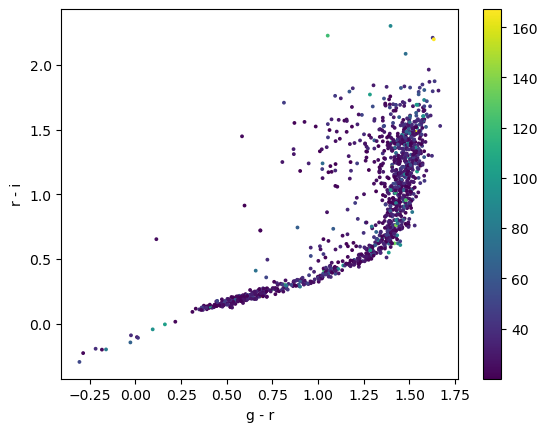

In [14]:
import matplotlib.pyplot as plt
ax = plt.subplot()
im = ax.scatter(
    high_pm_ztf_sample["g_minus_r"],
    high_pm_ztf_sample["r_minus_i"],
    c=high_pm_ztf_sample["pm"],
    s=3,
)
ax.set_xlabel("g - r")
ax.set_ylabel("r - i")
plt.colorbar(im)
plt.show()

In [15]:
client.shutdown()